In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

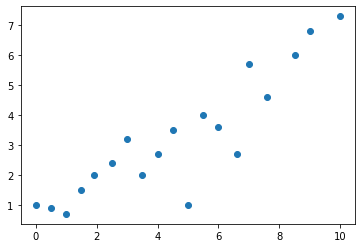

In [2]:
data = [[0.0, 0.5, 1.0, 1.5, 1.9, 2.5, 3.0, 3.5, 4.0, 4.5, 
         5.0, 5.5, 6.0, 6.6, 7.0, 7.6, 8.5, 9.0, 10.0],
        [1.0, 0.9, 0.7, 1.5, 2.0, 2.4, 3.2, 2.0, 2.7, 3.5, 
         1.0, 4.0, 3.6, 2.7, 5.7, 4.6, 6.0, 6.8,  7.3]]

values = pd.DataFrame(data).transpose().rename(columns={0: 'x', 1:'y'})
values.index += 1

I = values.index

axes = plt.scatter(values.x, values.y)

### Case 1: Straight Line, Minimizing Absolute Deviation

Absolute Deviation is the total sum of slack and surplus variables

In [3]:
model1 = gp.Model('Curve Fitting case1')

# add vars
a_c1 = model1.addVar(lb=-float('inf'), ub=float('inf'),
                  name='linear_coeff',)
b_c1 = model1.addVar(lb=-float('inf'), ub=float('inf'),
                  name='angular_coeff',)
u_c1 = model1.addVars(I,
                  name='slack')
v_c1 = model1.addVars(I,
                  name='surplus')

# objective function
model1.setObjective((gp.quicksum(u_c1[i] + v_c1[i] for i in I)),
                    GRB.MINIMIZE)

# add constraints
model1.addConstrs((b_c1*values.x[i] + a_c1 + u_c1[i] - v_c1[i] == values.y[i] for i in I),
                  name='fit')

model1.update()

Using license file C:\Users\Nara\gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-12


In [4]:
model1.write('Curve Fitting case1.lp')
model1.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 19 rows, 40 columns and 75 nonzeros
Model fingerprint: 0x2f6533c8
Coefficient statistics:
  Matrix range     [5e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 7e+00]
Presolve time: 0.02s
Presolved: 19 rows, 40 columns, 75 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      20    1.1466250e+01   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.04 seconds
Optimal objective  1.146625000e+01


Linear Coefficient  =  0.58125
Angular Coefficient =  0.6375


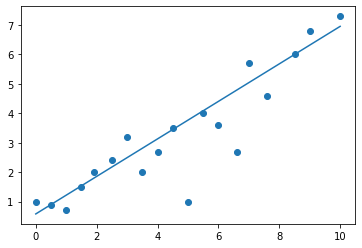

In [5]:
print('Linear Coefficient  = ', a_c1.x)
print('Angular Coefficient = ', b_c1.x)

fitted_line_x = [values.x[i] for i in I]
fitted_line_y = [b_c1.x*values.x[i] + a_c1.x for i in I]
plt.scatter(values.x, values.y)
plt.plot(fitted_line_x, fitted_line_y)

### Case 2: Straight Line, Minimizing Maximum Deviation

In [6]:
model2 = gp.Model('Curve Fitting case2')

# add vars
a_c2 = model2.addVar(lb=-float('inf'), ub=float('inf'),
                  name='linear_coeff',)
b_c2 = model2.addVar(lb=-float('inf'), ub=float('inf'),
                  name='angular_coeff',)
u_c2 = model2.addVars(I,
                  name='slack')
v_c2 = model2.addVars(I,
                  name='surplus')
z_c2 = model2.addVar(name='max_deviation',)

# objective function
model2.setObjective((z_c2),
                    GRB.MINIMIZE)

# add constraints
model2.addConstrs((b_c2*values.x[i] + a_c2 + u_c2[i] - v_c2[i] == values.y[i] for i in I),
                  name='fit')
model2.addConstrs((z_c2 - u_c2[i] >= 0 for i in I),
                  name='max_dev_u')
model2.addConstrs((z_c2 - v_c2[i] >= 0 for i in I),
                  name='max_dev_v')

model2.update()

In [7]:
model2.write('Curve Fitting case2.lp')
model2.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57 rows, 41 columns and 151 nonzeros
Model fingerprint: 0xdca72e84
Coefficient statistics:
  Matrix range     [5e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 7e+00]
Presolve time: 0.01s
Presolved: 57 rows, 41 columns, 151 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      26    1.7250000e+00   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.02 seconds
Optimal objective  1.725000000e+00


Linear Coefficient  =  -0.3999999999999999
Angular Coefficient =  0.625


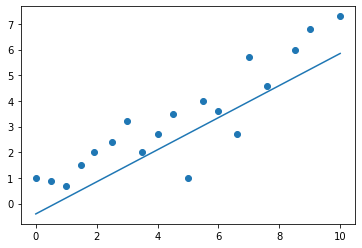

In [8]:
print('Linear Coefficient  = ', a_c2.x)
print('Angular Coefficient = ', b_c2.x)

fitted_line_x = [values.x[i] for i in I]
fitted_line_y = [b_c2.x*values.x[i] + a_c2.x for i in I]
plt.scatter(values.x, values.y)
plt.plot(fitted_line_x, fitted_line_y)

### Case 3: Quadratic Line, Minimizing Absolute Deviation

In [9]:
model3 = gp.Model('Curve Fitting case3')

# add vars
a_c3 = model3.addVar(lb=-float('inf'), ub=float('inf'),
                  name='a_coeff',)
b_c3 = model3.addVar(lb=-float('inf'), ub=float('inf'),
                  name='b_coeff',)
c_c3 = model3.addVar(lb=-float('inf'), ub=float('inf'),
                  name='c_coeff',)
u_c3 = model3.addVars(I,
                  name='slack')
v_c3 = model3.addVars(I,
                  name='surplus')

# objective function
model3.setObjective((gp.quicksum(u_c3[i] + v_c3[i] for i in I)),
                    GRB.MINIMIZE)

# add constraints
model3.addConstrs((c_c3*values.x[i]**2 + b_c3*values.x[i] + a_c3 + u_c3[i] - v_c3[i] == values.y[i] for i in I),
                  name='fit')

model3.update()

In [10]:
model3.write('Curve Fitting case3.lp')
model3.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 19 rows, 41 columns and 93 nonzeros
Model fingerprint: 0x180f77a9
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 7e+00]
Presolve time: 0.01s
Presolved: 19 rows, 41 columns, 93 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      19    1.0458965e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.02 seconds
Optimal objective  1.045896471e+01


A Coefficient =  0.9823529411764703
B Coefficient =  0.2945098039215688
C Coefficient =  0.03372549019607842


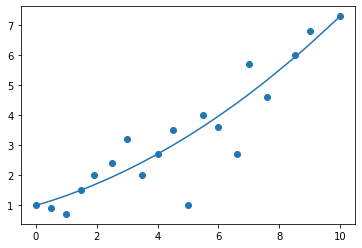

In [11]:
print('A Coefficient = ', a_c3.x)
print('B Coefficient = ', b_c3.x)
print('C Coefficient = ', c_c3.x)

fitted_line_x = [values.x[i] for i in I]
fitted_line_y = [c_c3.x*values.x[i]**2 + b_c3.x*values.x[i] + a_c3.x for i in I]
plt.scatter(values.x, values.y)
plt.plot(fitted_line_x, fitted_line_y)

### Case 4: Quadratic Line, Minimizing Maximum Deviation

In [12]:
model4 = gp.Model('Curve Fitting case4')

# add vars
a_c4 = model4.addVar(lb=-float('inf'), ub=float('inf'),
                  name='a_coeff',)
b_c4 = model4.addVar(lb=-float('inf'), ub=float('inf'),
                  name='b_coeff',)
c_c4 = model4.addVar(lb=-float('inf'), ub=float('inf'),
                  name='c_coeff',)
u_c4 = model4.addVars(I,
                  name='slack')
v_c4 = model4.addVars(I,
                  name='surplus')
z_c4 = model4.addVar(name='max_deviation',)

# objective function
model4.setObjective((z_c4),
                    GRB.MINIMIZE)

# add constraints
model4.addConstrs((c_c4*values.x[i]**2 + b_c4*values.x[i] + a_c4 + u_c4[i] - v_c4[i] == values.y[i] for i in I),
                  name='fit')
model4.addConstrs((z_c4 - u_c4[i] >= 0 for i in I),
                  name='max_dev_u')
model4.addConstrs((z_c4 - v_c4[i] >= 0 for i in I),
                  name='max_dev_v')

model4.update()

In [13]:
model4.write('Curve Fitting case4.lp')
model4.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57 rows, 42 columns and 169 nonzeros
Model fingerprint: 0xb52156df
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 7e+00]
Presolve time: 0.01s
Presolved: 57 rows, 42 columns, 169 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      16    1.4750000e+00   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.02 seconds
Optimal objective  1.475000000e+00


A Coefficient =  2.475
B Coefficient =  -0.625
C Coefficient =  0.125


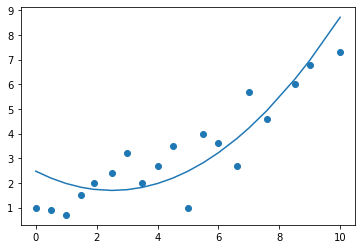

In [14]:
print('A Coefficient = ', a_c4.x)
print('B Coefficient = ', b_c4.x)
print('C Coefficient = ', c_c4.x)

fitted_line_x = [values.x[i] for i in I]
fitted_line_y = [c_c4.x*values.x[i]**2 + b_c4.x*values.x[i] + a_c4.x for i in I]
plt.scatter(values.x, values.y)
plt.plot(fitted_line_x, fitted_line_y)